# 使用 Numba 实现高斯模糊

让我们尝试做一些更复杂的事情。让我们获取一张图像并使用 GPU 应用高斯模糊。

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import cuda
from numba import config as numba_config
import numpy as np
import math

numba_config.CUDA_ENABLE_PYNVJITLINK = True
plt.rcParams["figure.figsize"] = (30, 4)

## 数据加载

我们可以将图像文件读取为 NumPy 数组。让我们使用 Numba 的 logo。

In [2]:
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/main/gpu-python-tutorial/images/numba.png
im = plt.imread("numba.png")

--2025-11-11 20:10:22--  https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/main/gpu-python-tutorial/images/numba.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3809 (3.7K) [image/png]
Saving to: ‘numba.png.1’

numba.png.1         100%[===================>]   3.72K  --.-KB/s    in 0s      

2025-11-11 20:10:23 (58.7 MB/s) - ‘numba.png.1’ saved [3809/3809]



In [3]:
type(im)

numpy.ndarray

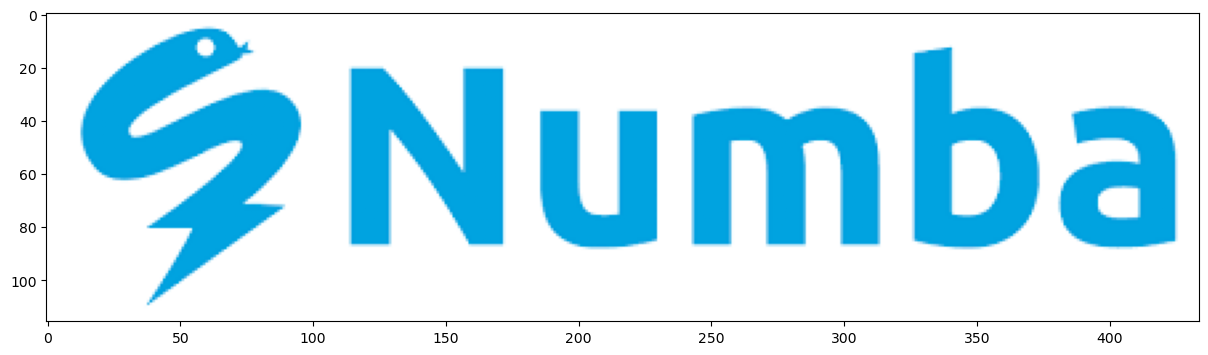

In [5]:
plt.imshow(im)

让我们将图像移动到 GPU，并创建一个输出数组来存储模糊后的图像。

In [4]:
gpu_im = cuda.to_device(im)
gpu_output = cuda.to_device(np.zeros_like(gpu_im))

## 多维索引

在编写模糊函数之前，让我们先讨论多维索引。在之前的示例中，我们使用 `cuda.grid(1)` 来获取 `i` 值。这个调用中的 `1` 表示索引应该具有的维度数。我们处理的是一维数组，所以使用一维索引是合理的。

现在我们处理的是一张图像，它有三个维度：两个维度用于 `x` 和 `y`，一个维度用于 `channel`（红、绿、蓝、透明度）。

In [5]:
im.shape

(116, 434, 4)

我们希望 CUDA 内核对图像中的每个像素进行操作。我们可以继续使用 `i`，确保 `i` 为 `116 * 434 * 4`，然后自己展开索引来确定我们想要的像素。

但我们可以使用三维索引，这样就可以用 `x`、`y` 和 `channel` 索引来代替 `i`。

首先，我们需要指定一个三维线程块大小。让我们继续使用线程块大小 `128`，但可以将其指定为三个相乘等于 `128` 的数字。

In [6]:
# threadsperblock = 128
threadsperblock = (2, 16, 4)

接下来我们需要计算网格大小。我们将使用图像的维度来计算覆盖图像所需的线程数。

In [7]:
blockspergrid_x = math.ceil(gpu_im.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(gpu_im.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(gpu_im.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

In [8]:
blockspergrid

(58, 28, 1)

如果我们将线程数和块数相乘，可以看到我们的网格比图像稍大一些。

In [9]:
[t * b for t, b in zip(threadsperblock, blockspergrid)]

[116, 448, 4]

## 编写模糊内核

我们的内核需要接收图像和输出数组。

它需要获取要操作的网格位置，然后对该位置的图像执行模糊。

我们只关心在 `x` 和 `y` 维度上进行模糊，而不是在颜色通道上。所以我们只需直接传递 `c` 值。

In [10]:
@cuda.jit
def blur(im, output):
    # 使用三维网格，我们可以获取三个维度的索引位置
    x, y, c = cuda.grid(3)

    # 因为我们的网格比图像稍大，所以应该忽略图像外的任何内容
    if x < im.shape[0] and y < im.shape[1] and c < im.shape[2]:

        # 将输出数组的像素设置为输入数组中该点周围九个像素的平均值
        output[x, y, c] = (im[x-1, y-1, c] + im[x, y-1, c] + im[x+1, y-1, c]  + \
                           im[x-1, y, c]   + im[x, y, c]   + im[x+1, y, c]    + \
                           im[x-1, y+1, c] + im[x+1, y, c] + im[x+1, y+1, c]) / 9

## 运行内核

现在让我们多次运行内核以获得所需的模糊级别。

我们需要在开始下一次之前完成每一次传递。我们还需要将输出变成输入，并需要一个新的输出来工作。我们可以重用旧的输入作为新的输出数组。这很高效，因为我们可以重用 GPU 上的两个现有数组。

这就是手动内存管理派上用场的地方。我们可以多次调用内核，但将所有数据保留在 GPU 上。我们只需在每次传递之间交换指针。

In [11]:
for i in range(5):
    blur[blockspergrid, threadsperblock](gpu_im, gpu_output)
    gpu_im, gpu_output = gpu_output, gpu_im

现在如果我们查看图像，它应该已经足够模糊了。

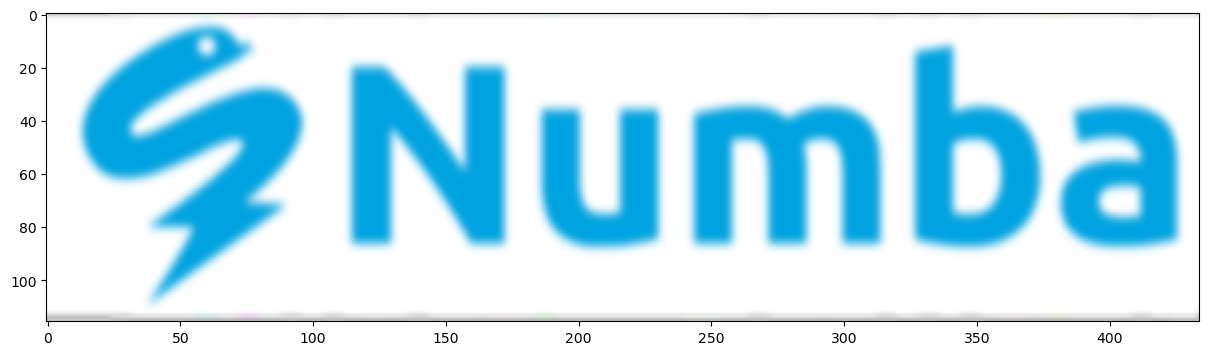

In [12]:
plt.imshow(gpu_output.copy_to_host())